In [1]:
import torch

In [2]:
conv = torch.nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [3]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [4]:
from torchvision import datasets
from torchvision import transforms

data_path= '../dataset'
cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]),
)

cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))]),
)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [6]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.shape, img.unsqueeze(0).shape, output.shape

(torch.Size([3, 32, 32]),
 torch.Size([1, 3, 32, 32]),
 torch.Size([1, 16, 30, 30]))

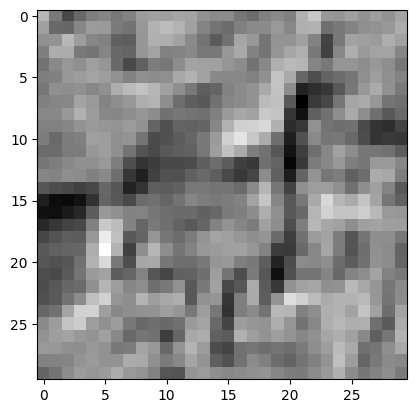

In [18]:
import matplotlib.pyplot as plt

plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


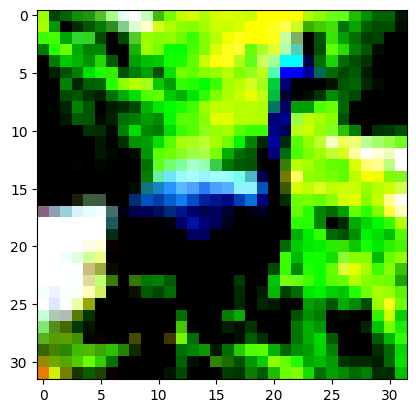

torch.Size([30, 30])

In [20]:
plt.imshow(img.detach().permute(1,2,0))
plt.show()

output[0,0].shape

In [21]:
# before padding, output shape: torch.Size([1, 16, 30, 30])
conv = torch.nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

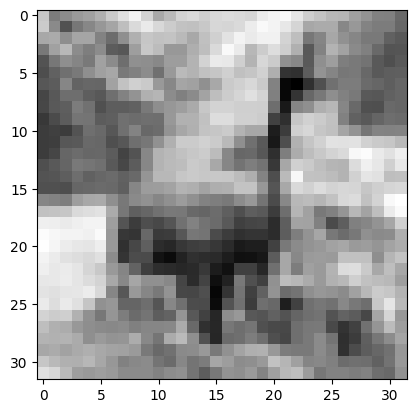

In [26]:
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

plt.imshow(img.detach()[0], cmap='gray')
plt.show()

In [27]:
with torch.no_grad():
    conv.bias.zero_()

with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

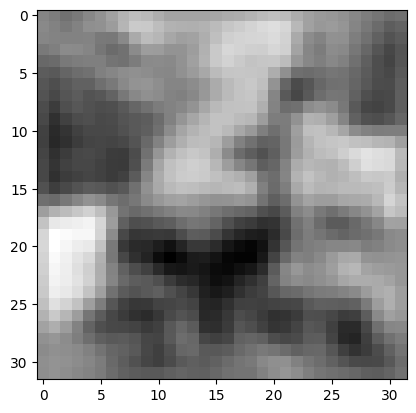

In [28]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

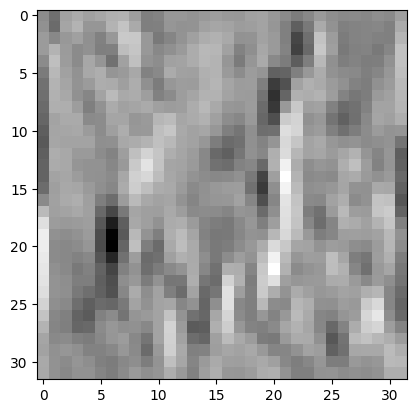

In [29]:
conv = torch.nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0],
        [-1.0, 0.0, 1.0]
    ])
    conv.bias.zero_()

output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap='gray')
plt.show()

In [30]:
pool = torch.nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [31]:
import torch
from torch import nn

model = torch.nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    # ⇽---  警告：缺少了一些重要的东西
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32,2)
)

In [38]:
output = model(img.unsqueeze(0))
print(output)

tensor([[ 0.0727, -0.0344]], grad_fn=<AddmmBackward0>)


In [33]:
import torch
from torch import nn
import torch.nn.functional as F 

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [39]:
model = Net()
output = model(img.unsqueeze(0))

print(output)

tensor([[-0.0277, -0.1065]], grad_fn=<AddmmBackward0>)


In [58]:
import datetime

def train_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            # 除以训练数据加载器的长度，得到每批平均损失，这是一种比求总和更直观的方法
            print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))

In [61]:
from torch import optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

train_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader
)

2024-03-12 15:16:30.687509 Epoch 1, Training loss 0.5643786799376178
2024-03-12 15:16:50.752105 Epoch 10, Training loss 0.32853695256694865
2024-03-12 15:17:13.430170 Epoch 20, Training loss 0.2965644488858569
2024-03-12 15:17:36.219687 Epoch 30, Training loss 0.26960844798072886
2024-03-12 15:18:00.138857 Epoch 40, Training loss 0.2486938649112252
2024-03-12 15:18:26.650353 Epoch 50, Training loss 0.2318007345696923
2024-03-12 15:18:53.134448 Epoch 60, Training loss 0.21605107321101388
2024-03-12 15:19:17.823381 Epoch 70, Training loss 0.19901176577635632
2024-03-12 15:19:42.064753 Epoch 80, Training loss 0.18368575185727162
2024-03-12 15:20:06.372116 Epoch 90, Training loss 0.17365955532925903
2024-03-12 15:20:30.705631 Epoch 100, Training loss 0.15949679042693157


In [63]:
data_path = './'
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [40]:
data_path = './'

loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [45]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predict = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predict == labels).sum())

        print("accuracy {}: {:.2f}".format(name, correct / total))


validate(loaded_model, train_loader, val_loader)

accuracy train: 0.93
accuracy val: 0.90


In [73]:
# 非原地操作
a = torch.tensor([1, 2, 3], requires_grad=True, dtype=float)
b = torch.tensor([4, 5, 6], requires_grad=True, dtype=float)
c = a + b
d = c.sum()
d.backward()

print(a.grad)  # 输出: tensor([1, 1, 1])
print(b.grad)  # 输出: tensor([1, 1, 1])


a_clone = a.clone()
a_clone += b

c = a_clone.sum()
c.backward()

#print(a.grad)  # 输出: None
#print(a_clone.grad)  # 输出: tensor([1, 1, 1])

# 原地操作
a = torch.tensor([1, 2, 3], requires_grad=True, dtype=float)
b = torch.tensor([4, 5, 6], requires_grad=True, dtype=float)
a += b
c = a.sum()
c.backward()

print(a.grad)  # 输出: tensor([2, 2, 2])

tensor([1., 1., 1.], dtype=torch.float64)
tensor([1., 1., 1.], dtype=torch.float64)


RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [71]:
with torch.no_grad():
    a += b

c = a.sum()
c.backward()

print(a.grad)  # 输出: tensor([1, 1, 1])


tensor([1., 1., 1.], dtype=torch.float64)


In [74]:
x = torch.tensor([1., 2.], requires_grad=True)
y = x * 2 # y作为计算图中间节点,保存了对x的引用
y.add_(1) # 原地修改y,但y节点保存的x.data已经被改变
z = y * y # 由于y节点的输入值已被修改,z节点无法正确计算梯度
z.backward()
print(x.grad) # 输出None,而非期望的[4., 8.]

RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:         
            imgs = imgs.to(device=device)         
            labels = labels.to(device=device)   

            outputs = model(imgs)         
            loss = loss_fn(outputs, labels)   

            l2_lambda = 0.001         
             # 对L1正则化则使用abs()替换pow(2.0)         
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm 
                    
            optimizer.zero_grad()         
            loss.backward()         
            optimizer.step()         
            loss_train += loss.item()        
            
    if epoch == 1 or epoch % 10 == 0:         
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader))

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# 实例化模型
model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [6]:
import torch
import torch.nn as nn

loss = nn.functional.l1_loss
input = torch.tensor([0, 0, 0], dtype=torch.float32)
target = torch.tensor([0, 0, 0], dtype=torch.float32)
output = loss(input, target)
output = output.detach().numpy()
print(output)

0.0
